<a href="https://colab.research.google.com/github/Mctran1724/Disaster-Tweets-NLP/blob/main/disaster_tweets_gpu_v3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

We want to train on GPU if possible so let's set that up

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
folder = "/content/drive/MyDrive/DSdata/nlpdisastertweet"
train = pd.read_csv(folder + '/train.csv')
test = pd.read_csv(folder + '/test.csv')


So there are some tweets in the "text" column, and some targets, based on whether they are disasters or not. We can do some feature engineering on like whether there's disaster keywords with # or whatever. We should do some EDA. 

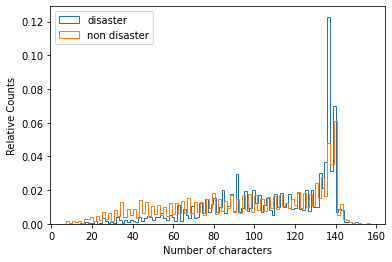

In [5]:
#Most obvious thing is tweet length. 
#I would expect that true disaster tweets are shorter, due to their immediate emergency status.
#Let's check
disastertweetlens = np.array([len(tweet) for tweet in train[train.target ==1].text], dtype = 'float32')
nondisastertweetlens = np.array([len(tweet) for tweet in train[train.target ==0].text], dtype = 'float32')

#Normalizing the histogram so that the y axis is relative frequency and the two can be directly compared.
#Obviously the max number of characters in a tweet is fixed at 160 so it's a moot point to adjust those.
disasterweights = np.ones_like(disastertweetlens)/float(len(disastertweetlens))
nondisasterweights = np.ones_like(nondisastertweetlens)/float(len(nondisastertweetlens))



plt.hist(disastertweetlens, histtype = 'step', label = 'disaster', weights = disasterweights, bins = 100)
plt.hist(nondisastertweetlens, histtype='step', label = 'non disaster', weights = nondisasterweights, bins = 100)
plt.xlabel("Number of characters")
plt.ylabel("Relative Counts")
plt.legend(loc = 2)
plt.show()



As it turns out, you cannot purely cut on the number of characters... However, it seems that non disaster tweets are not as verbose. Perhaps information about the distribution itself could be a thing to train on. Maybe density estimation??

In [6]:
#First we focus on how the punctuation plays a role... 
#Because you'd imagine people have different #blahblah usage or tagging
import string
print(string.punctuation)
#Let's check number of occurances of each character in the strings
punctuations = string.punctuation

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


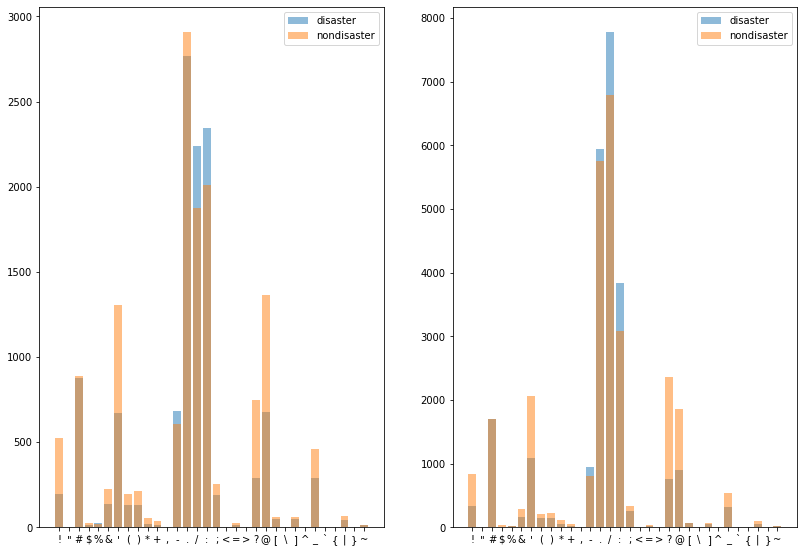

In [7]:
charsnondisaster = {}
charsnondisastercum = {}
for char in punctuations:
    count = 0
    countcum = 0
    for tweet in train[train.target == 0].text:
        if char in tweet:
            count += 1
        countcum += tweet.count(char)
    charsnondisaster[char] = count
    charsnondisastercum[char] = countcum

charsdisaster = {}
charsdisastercum = {}
for char in punctuations:
    count = 0
    countcum = 0
    for tweet in train[train.target == 1].text:
        if char in tweet:
            count += 1
        countcum += tweet.count(char)
    charsdisaster[char] = count
    charsdisastercum[char] = countcum


fig, ax = plt.subplots(1,2)
ax[0].bar(charsdisaster.keys(), [charsdisaster[key] for key in charsdisaster.keys()], label = 'disaster', alpha = 0.5)
ax[0].bar(charsnondisaster.keys(), [charsnondisaster[key] for key in charsnondisaster.keys()], label = 'nondisaster',alpha = 0.5)
ax[0].legend()

fig.tight_layout()
ax[1].bar(charsdisastercum.keys(), [charsdisastercum[key] for key in charsdisastercum.keys()], label = 'disaster', alpha = 0.5)
ax[1].bar(charsnondisastercum.keys(), [charsnondisastercum[key] for key in charsnondisastercum.keys()], label = 'nondisaster',alpha = 0.5)
ax[1].legend()
plt.subplots_adjust(left = 0.0001)
fig.set_size_inches(11, 8.5)

plt.show()

It is interesting that the use of "#" is the same in both disasters and nondisasters either way. People that use periods have more sentences in disasters than nondisasters. People seem to use multiple instances of "/" preferrentialy in disasters. There are some other insights as well. Time to check out the keywords and locations...

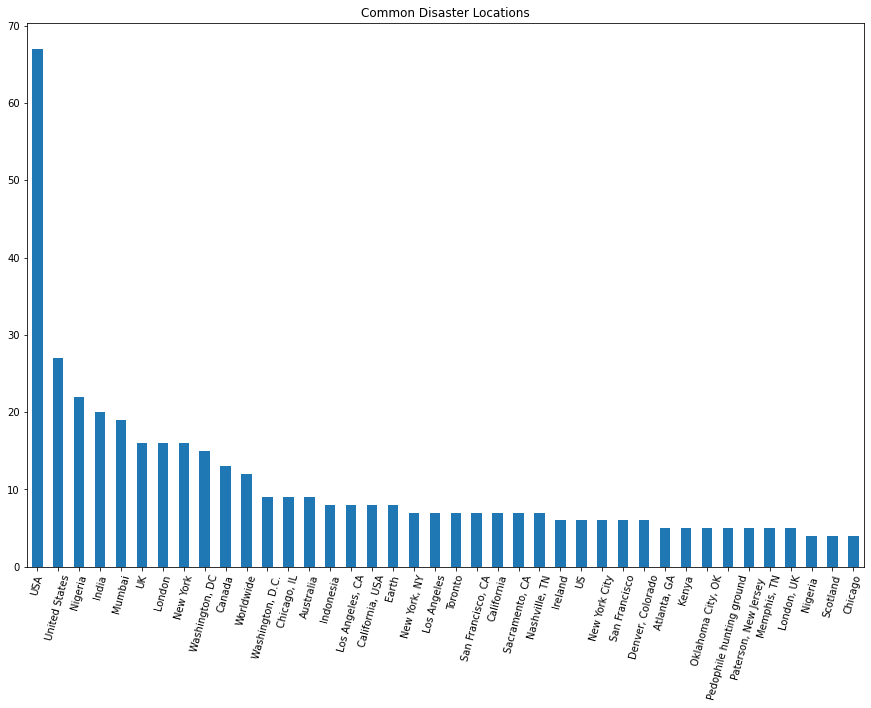

In [8]:
plt.figure(figsize = (15,10))
disasterlocs = train[train["target"]==1]["location"]
disasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Disaster Locations")
plt.show()

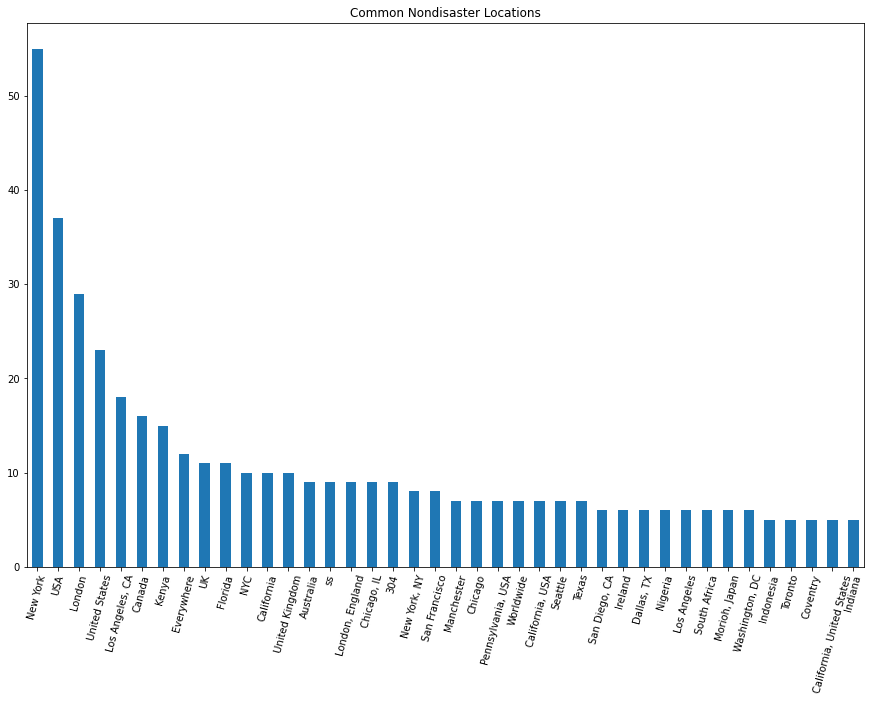

In [9]:
plt.figure(figsize = (15,10))
nondisasterlocs = train[train["target"]==0]["location"]
nondisasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Nondisaster Locations")
plt.show()

We'll do the same for the keywords

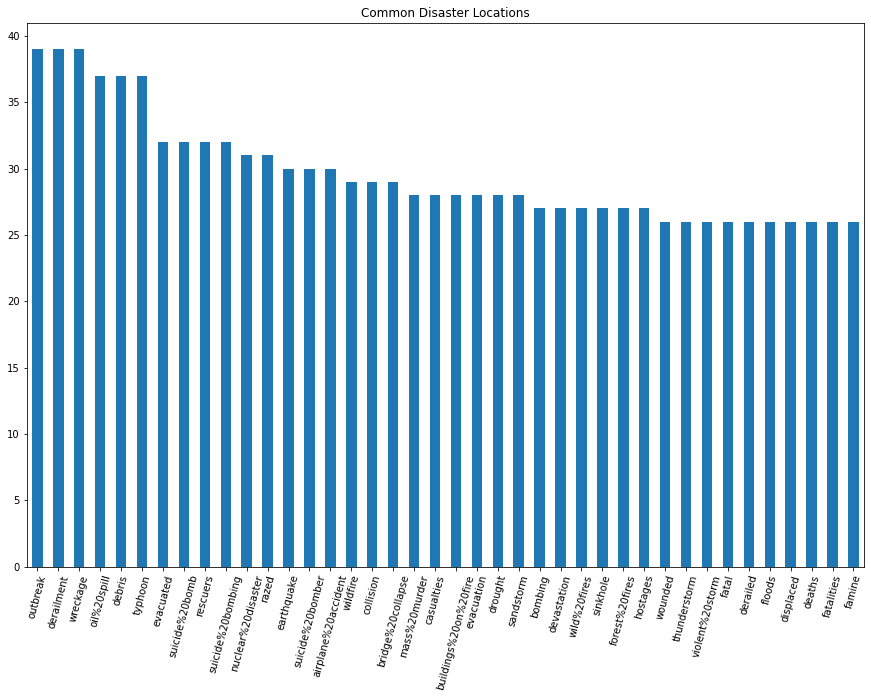

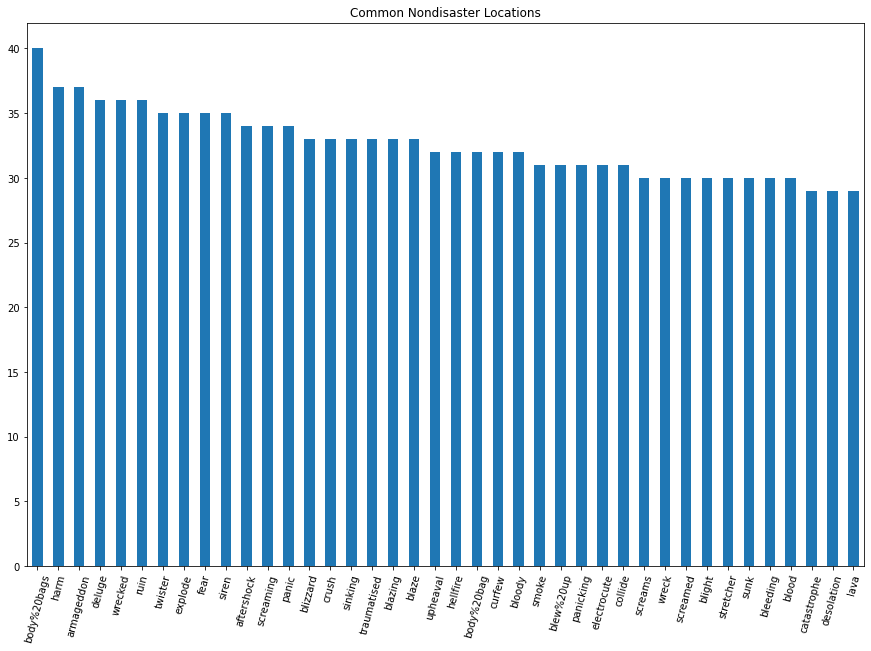

In [10]:
plt.figure(figsize = (15,10))
disasterlocs = train[train["target"]==1]["keyword"]
disasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Disaster Locations")
plt.show()

plt.figure(figsize = (15,10))
nondisasterlocs = train[train["target"]==0]["keyword"]
nondisasterlocs.value_counts()[:40].plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.title("Common Nondisaster Locations")
plt.show()

Now for some preprocessing. First thing is to remove tagged users, since the user who was tagged doesn't contain information about the text. Tags have @ in them. For #, remove the "#" since that doesn't contain information just like @ and other special characters. Remove stopwords, since they contain little information. etc.

In [11]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re


def strip_prefixes(text):
    entity_prefixes = ['@']
    for separator in string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def strip_stopwords(text):
    sw = set(stopwords.words("english"))
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in sw:
                words.append(word)
    return " ".join(words)

def strip_web(text):
    a = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',text) #Removing stuff that has webpage looking strings
    b = re.sub(r'<.*?>',' ', a) #Removing HTML tags
    c = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ', b)
    return c


def find_prefix(text, symbol):
    if text.__contains__(symbol):
        return 1
    else: 
        return 0
    
    
def clean_data(textdf, stemmer, cleanedname):
    textdf['hashtags'] = textdf['text'].apply(lambda x: find_prefix(x, "#"))
    textdf['tags'] = textdf['text'].apply(lambda x: find_prefix(x, "@"))
    textdf['text_cleaned'] = textdf['text'].apply(lambda x: strip_web(x))
    textdf['text_cleaned'] = textdf['text_cleaned'].apply(lambda x: x.lower())
    textdf['text_cleaned'] = textdf['text_cleaned'].apply(lambda x: strip_prefixes(x))
    textdf['text_cleaned'] = textdf['text_cleaned'].apply(lambda x: strip_stopwords(x))
    textdf[cleanedname] = textdf['text_cleaned'].apply(lambda x: stemmer.stem(x))
    return textdf 

In [12]:
import nltk 
nltk.download('stopwords')

pstem = PorterStemmer()
sstem = SnowballStemmer('english')
cleanedname = "Porter_stemmed"
train = clean_data(train, pstem, cleanedname)
test = clean_data(test, pstem, cleanedname)

train.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,keyword,location,text,target,hashtags,tags,text_cleaned,Porter_stemmed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,0,reason earthquake forgive us,reason earthquake forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,forest fire near la ronge canada,forest fire near la ronge canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,0,residents place being notified by no evacuatio...,residents place being notified by no evacuatio...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,0,13 000 people receive wildfires evacuation cal...,13 000 people receive wildfires evacuation cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,0,just got photo from ruby from wildfires pours,just got photo from ruby from wildfires pour


Instead of training new word vectors or something like that (with word2vec or similar), I'll use GloVe since they've done a fantastic job scraping text corpora and embedding.


In [13]:
#Import the glove word vectors
import pickle

wvs={}
with open("/content/drive/MyDrive/DSdata/glove.twitter.27B.200d.txt",'r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        wvs[word]=vectors


Choose the text to train on and instantiate Tokenizer.

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

traintext = train['Porter_stemmed']
testtext = test['Porter_stemmed']
tok = Tokenizer()
tok.fit_on_texts(traintext)

vocab_size = len(tok.word_index)+1
print("The vocabulary size is : {}".format(vocab_size))
encoded_train = tok.texts_to_sequences(traintext)
encoded_test = tok.texts_to_sequences(testtext)
max_length = 120
X = pad_sequences(encoded_train,maxlen=max_length,padding='post') # This is done to make the sequence of same length.
test_features = pad_sequences(encoded_test, maxlen = max_length, padding = 'post')
y = train['target']
print(X.shape)
print(y.shape)
wvsize = len(wvs['hi'])
inshape = vocab_size
outshape = wvsize

#Split training and testing data. Only for use for designing model.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)


The vocabulary size is : 9679
(7613, 120)
(7613,)


In [15]:
wvm = np.zeros((vocab_size,wvsize))
for word,index in tok.word_index.items():
    vector = wvs.get(word)
    if vector is not None:
        wvm[index] = vector
print(wvm.shape)

(9679, 200)


#Try adaboost classifier

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc


def binary(vector, cut = 0.5):
    results = np.zeros(len(vector))
    for i, x in enumerate(vector):
        if x >= cut:
            results[i] = 1
    return results.reshape(-1,1)


bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=500, 
                         random_state=7)



bdt.fit(x_train, y_train)

class_preds = binary(bdt.predict(x_test))
print(accuracy_score(class_preds, np.array(y_test).reshape(-1,1)))


0.6338582677165354


#Try LSTM model

In [18]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Bidirectional, Dense 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


LSTMmodel = keras.Sequential()
LSTMmodel.add(Embedding(inshape, outshape, input_length = max_length, weights = [wvm], trainable = False))
LSTMmodel.add(Dropout(0.35))
LSTMmodel.add(LSTM(200))
LSTMmodel.add(Dropout(0.20))
LSTMmodel.add(Dense(64,activation='relu'))
LSTMmodel.add(Dropout(0.15))
LSTMmodel.add(Dense(32,activation='relu'))
LSTMmodel.add(Dropout(0.35))
LSTMmodel.add(Dense(1,activation='sigmoid'))
LSTMmodel.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4),metrics=['accuracy'])
LSTMmodel.summary()
model = LSTMmodel


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 200)          1935800   
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 200)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12864     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

Include some stop condition based on validation data

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, 
                           mode='min', restore_best_weights=True)

checkpoint=tf.keras.callbacks.ModelCheckpoint('model.h5',monitor='val_loss',save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='min')


For the training, we want to use GPU if possible

In [20]:
num_epochs = 30
if "GPU" in device_name:
    with tf.device(device_name):
        print("GPU")
        model.fit(x_train,y_train,validation_split=0.2,
          callbacks=[early_stop, checkpoint, reduce_lr],epochs=num_epochs,batch_size=64, verbose = 2)
else:
    print("CPU")
    model.fit(x_train,y_train,validation_split=0.2,
          callbacks=[early_stop, checkpoint, reduce_lr],epochs=num_epochs,batch_size=64, verbose = 2)

model.save_weights("./weights.h5")


GPU
Epoch 1/30
86/86 - 34s - loss: 0.6891 - accuracy: 0.5693 - val_loss: 0.6805 - val_accuracy: 0.5748
Epoch 2/30
86/86 - 1s - loss: 0.6301 - accuracy: 0.6511 - val_loss: 0.5712 - val_accuracy: 0.7265
Epoch 3/30
86/86 - 1s - loss: 0.5579 - accuracy: 0.7526 - val_loss: 0.5388 - val_accuracy: 0.7454
Epoch 4/30
86/86 - 1s - loss: 0.5329 - accuracy: 0.7646 - val_loss: 0.5227 - val_accuracy: 0.7600
Epoch 5/30
86/86 - 1s - loss: 0.5308 - accuracy: 0.7608 - val_loss: 0.5375 - val_accuracy: 0.7513
Epoch 6/30
86/86 - 1s - loss: 0.5258 - accuracy: 0.7692 - val_loss: 0.5179 - val_accuracy: 0.7520
Epoch 7/30
86/86 - 1s - loss: 0.5121 - accuracy: 0.7745 - val_loss: 0.5130 - val_accuracy: 0.7520
Epoch 8/30
86/86 - 1s - loss: 0.5102 - accuracy: 0.7750 - val_loss: 0.5159 - val_accuracy: 0.7615
Epoch 9/30
86/86 - 1s - loss: 0.5090 - accuracy: 0.7723 - val_loss: 0.5129 - val_accuracy: 0.7586
Epoch 10/30
86/86 - 1s - loss: 0.5072 - accuracy: 0.7783 - val_loss: 0.5114 - val_accuracy: 0.7600
Epoch 11/30
86

Now we can use the weight to make some predictions and see how good they are. Maybe some later time I'll change it so that you can cut and the predictions of 0.6 or 0.7 or whatever count as disaster tweets too I'm not sure.

In [21]:
predictions = model.predict(x_test)
train_labels = np.array(y_test).reshape(-1,1) 
class_preds = binary(predictions, 0.6)
print(accuracy_score(class_preds,train_labels))

0.7874015748031497


Put the answers together.

In [22]:
ans = binary(model.predict(test_features), 0.6)
answers = pd.DataFrame(ans)
answers_id = test['id']
submission = pd.concat([answers_id,answers],axis=1)
submission.columns = ["id","target"]

submission.to_csv("submission3.csv", index=False)




#Can we improve performance by including the hashtags/tagging? 
Future directions: Include secondary input layer that updates the identity using the prediction based on the actual NLP and the usage of hashtags and tagging.


In [23]:
def new_features(previous_features, HLFS):
    NNpreds = LSTMmodel.predict(previous_features).reshape(-1,1)
    return np.column_stack((NNpreds,HLFS))


trainHLFs = np.column_stack((train['hashtags'], train['tags']))
newtrainfeatures = new_features(X, trainHLFs)

x_train2, x_test2, y_train2, y_test2 = train_test_split(newtrainfeatures, y, test_size = 0.1, random_state = 7)

In [24]:
#Try models: Adaboost, Small DNN
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 5), n_estimators=500, random_state=7)

bdt.fit(x_train2, y_train2)
print(accuracy_score(bdt.predict(x_test2),y_test2.to_numpy()))



0.7217847769028871


Adaboost does not improve it. What about a stronger classifier?

In [35]:
from tensorflow.keras.layers import Input

DNN2 = Sequential()
DNN2.add(Input((3,)))
DNN2.add(Dense(16, activation="relu"))
DNN2.add(Dropout(0.2))
DNN2.add(Dense(16, activation="relu"))
DNN2.add(Dense(1, activation = "sigmoid"))
DNN2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
DNN2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                64        
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [63]:
DNN2.fit(x_train2, np.array(y_train2).reshape(-1,1))
print(accuracy_score(DNN2.predict_classes(x_test2),np.array(y_test2).reshape(-1,1)))


215/215 [==============================] - 1s 2ms/step - loss: 0.5081 - accuracy: 0.7859
0.7834645669291339


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


It seems that checking for hashtags or tagging just does not improve classification. The NLP itself must be sufficient.